# Binary Neural Networks

Existing deep neural networks use 32 bits, 16 bits or 8 bits to encode each weight and activation, making them large, slow and power-hungry. This prohibits many applications in resource-constrained environments.

Binary Neural Network is a type of neural network which activations (also called features) and weights are 1-bit values in all the hidden layers (except the input and output layers). In a few words, BNN is an extremely compacted case of CNN - it has the same structure except for different precision activations and weights. The use of BNNs enables not only significant reduction in memory usage, but also huge computational complexity improvements - the replacement of multiply-accumulation operations by `XNOR` and `bitcount` operations.

Today, we'll use `Larq` - an open-source Python library for training neural networks with extremely low-precision weights and activations.

You can find out more here: https://docs.larq.dev/larq/.

Larq is built on top of `TensorFlow` which is Python library for training neural networks, just like `PyTorch`. Because of that, we need to get familiar with this framework.

First, install and import necessary libraries.

In [1]:
!pip install tensorflow==2.10
!pip install larq larq-zoo larq-compute-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

INFO: pip is looking at multiple versions of tensorflow-metadata to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.2/229.2 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully

In [3]:
import tensorflow as tf
import larq as lq

print("TensorFlow version:", tf.__version__)
print("Larq version:", lq.__version__)

TensorFlow version: 2.10.0
Larq version: 0.13.1


We'll stick with simple 3-conv-layers CNN and MNIST dataset. This time, we'll implement it with `TensorFlow`.

First, we use `tf.keras.datasets.mnist.load_data()` to download a dataset. Then, we need to reshape images to `(numer_of_samples, image_width, image_height, number_of_channels)`. Finally, we normalize image values to be between -1 and 1.

In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print(f'Train images: {train_images.shape}')
print(f'Test images: {test_images.shape}')

train_images = train_images.reshape((60000, train_images.shape[1], train_images.shape[2], 1 )) #TODO: Put the widht, height and number of channels here
test_images = test_images.reshape((10000, test_images.shape[1], test_images.shape[2], 1)) #TODO: Put the widht, height and number of channels here

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

Train images: (60000, 28, 28)
Test images: (10000, 28, 28)


Now, we need to create our model. We'll use the same architecture as in `PyTorch`:

```
nn.Conv2d(input_channels,32,3,padding=(1,1))
nn.BatchNorm2d(32)
nn.ReLU()
nn.MaxPool2d(2,2)

nn.Conv2d(32,32,3,padding=(1,1))
nn.BatchNorm2d(64)
nn.ReLU()
nn.MaxPool2d(2,2)

nn.Conv2d(32,32,3)
nn.BatchNorm2d(128)
nn.ReLU()

nn.Flatten(),
nn.Linear(CNN_out_size, num_of_cls),
nn.Softmax(dim=1)
```

In `TensorFlow` however, we define model with `tf.keras.models.Sequential()` and then we add layers one by one with `model.add()`.

Create model with the help of documentation (https://keras.io/api/layers/) and following tips. You're going to need following layers:

- In `PyTorch` we created convolutional layers with `Conv2d(in_ch, out_ch, kernel_size, padding=(x,x))`.  In `TrensorFlow` we use `tf.keras.layers.Conv2D(out_ch, kernel_size, strides=(x,x), padding="same")`.
- For `stride=(x,x)` and `padding="same"` we get the same result as with `padding=(x,x)` in PyTorch. We don't have to specify the number of input channels, but we have to specify `input_shape=(w,h,ch)` parameter for the first `Conv2D` layer.
- The activation function is not added as an additional layer, but as `activation="relu"` parameter to `Conv2D`.
- You'll need `tf.keras.layers.BatchNormalization(scale=False)`, `tf.keras.layers.MaxPooling2D((2, 2))`, `tf.keras.layers.Dense(output_size)` and `tf.keras.layers.Flatten()` layers.
- The last layer (softmax) in our model should be `tf.keras.layers.Activation("softmax")`.

In [11]:
CNN = tf.keras.models.Sequential()

CNN.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    padding='same',
    activation='relu',
    input_shape=(28, 28, 1))
) # TODO: Enter parameters
CNN.add(tf.keras.layers.BatchNormalization(scale=False))
CNN.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) # TODO: Add another layer

CNN.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    activation='relu')
)
CNN.add(tf.keras.layers.BatchNormalization(scale=False))
CNN.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

CNN.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    activation='relu')
)
CNN.add(tf.keras.layers.BatchNormalization(scale=False))

CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(10))
CNN.add(tf.keras.layers.Activation("softmax"))

# TODO: Add all layers (the same ones as in PyTorch CNN model)

Hopefully, we have our network ready to go! You can use `CNN.summary()` function to see our ready network with its shapes and parameters.

In [12]:
CNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       96        
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       192       
 hNormalization)                                                 
                                                      

Now, let's train our network! After defining model layers and connections we need to compile it with `model.compile()` function. Google it and study its arguments. We should use `adam` optimizer, `[’accuracy’]`
metric and `tf.keras.losses.SparseCategoricalCrossentropy` loss.

Then, we run training with `model.fit()` function. Google it and study its arguments. We'll train `CNN` with batch size of `64` for `5` epochs with `train_images` and `train_labels`. After training, evaluate network with `CNN.evaluate()`, where you pass only `test_images` and `test_labels`. Print the resulting accuracy. It should be around 99%!

In [14]:
CNN.compile(
    optimizer='adam',
    metrics=['accuracy'],
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
) # TODO: Fill the gaps

CNN.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=5
) # TODO: Fill the gaps

test_loss, test_acc = CNN.evaluate(x=test_images, y=test_labels) # TODO: Fill the gaps

# TODO: Print the accuracy.
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

Epoch 1/5
938/938 [==============================] - 102s 109ms/step - loss: 0.0866 - accuracy: 0.9747
Epoch 2/5
938/938 [==============================] - 109s 116ms/step - loss: 0.0428 - accuracy: 0.9876
Epoch 3/5
938/938 [==============================] - 110s 117ms/step - loss: 0.0319 - accuracy: 0.9904
Epoch 4/5
938/938 [==============================] - 99s 106ms/step - loss: 0.0261 - accuracy: 0.9926
Epoch 5/5
313/313 [==============================] - 5s 15ms/step - loss: 0.0585 - accuracy: 0.9864
Test accuracy: 0.9864000082015991
Test loss: 0.05845389515161514


We got familiar with `TensorFlow` basics and we can carry on with BNNs.

Create new model with `tf.keras.models.Sequential()` and call it `BNN`. Use `model.add()` function to add all necessary layers to this model. However, you'll need to replace all `Conv2D` and `Dense` layers with their binary counterparts. Use `lq.layers.QuantConv2D()` instead of `tf.keras.layers.Conv2D()` and `lq.layers.QuantDense()` instead of `tf.keras.layers.Dense()`.

They use more or less the same parameters, but additionally, you have to update their quantizers. In BNNs, the quantization function
$$
q(x) = \begin{cases}
    -1 & x < 0 \\\
    1 & x \geq 0
\end{cases}
$$
is used in the forward pass to binarize the activations and the latent full precision weights. The gradient of this function is zero almost everywhere which prevents the model from learning.

To be able to train the model, the gradient is instead estimated using the Straight-Through Estimator (STE):
$$
\frac{\partial q(x)}{\partial x} = \begin{cases}
    1 & \left|x\right| \leq 1 \\\
    0 & \left|x\right| > 1
\end{cases}
$$

In Larq this can be done by using `input_quantizer="ste_sign"` and `kernel_quantizer="ste_sign"`.
Additionally, the latent full precision weights are clipped to -1 and 1 using `kernel_constraint="weight_clip"`.

For the first `Conv2D` layer add parameters `kernel_quantizer="ste_sign"` and `kernel_constraint="weight_clip"`. For the next ones (both `QuantConv2D` and `QuantDense`) use those two and `input_quantizer="ste_sign"`. This is why we don't quantize the inputs to the first convolutional layer (as is common for BNN training). All other layers should stay the same as in `CNN`.

In [16]:
BNN = tf.keras.models.Sequential()

BNN.add(lq.layers.QuantConv2D(
    filters=32,
    kernel_size=(3, 3),
    padding='same',
    kernel_quantizer="ste_sign",        # Kwantyzacja wag
    kernel_constraint="weight_clip",    # Ograniczenie wag do [-1, 1]
    activation='relu',
    input_shape=(28, 28, 1)
))
BNN.add(tf.keras.layers.BatchNormalization(scale=False))
BNN.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

BNN.add(lq.layers.QuantConv2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    input_quantizer="ste_sign",         # Kwantyzacja aktywacji wejściowych
    kernel_quantizer="ste_sign",        # Kwantyzacja wag
    kernel_constraint="weight_clip",
    activation='relu'
))
BNN.add(tf.keras.layers.BatchNormalization(scale=False))
BNN.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

BNN.add(lq.layers.QuantConv2D(
    filters=128,
    kernel_size=(3, 3),
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    activation='relu'
))
BNN.add(tf.keras.layers.BatchNormalization(scale=False))


BNN.add(tf.keras.layers.Flatten())
BNN.add(lq.layers.QuantDense(
    units=10,
    input_quantizer="ste_sign",
    kernel_quantizer="ste_sign",
    kernel_constraint="weight_clip"
))

BNN.add(tf.keras.layers.Activation('softmax'))

You can use `lq.models.summary()` function to see our ready network with its shapes and parameters. Study the quantization summary at the bottom.

In [17]:
lq.models.summary(BNN)

+sequential_5 stats----------------------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                              (bit)                        x 1       x 1    (kB)                          |
+----------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 28, 28, 32)      288        32    0.16           0       225792 |
| batch_normalization_4            -  (-1, 28, 28, 32)        0        64    0.25           0            0 |
| max_pooling2d_3                  -  (-1, 14, 14, 32)        0         0       0           0            0 |
| quant_conv2d_1                   1  (-1, 14, 14, 64)    18432        64    2.50     3612672            0 |
| batch_normalization_5            -  (-1, 14, 14, 64)        0       128    0.50           0            0 |
| max_pooling2d_4  

Now, compile, fit for 5 epochs and evaluate your `BNN` (the same way as before). Print the result. Is such a network enough for such a task?

In [18]:
BNN.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
) # TODO: Fill the gaps

BNN.fit(
    x=train_images,
    y=train_labels,
    batch_size=64,
    epochs=5
) # TODO: Fill the gaps

test_loss, test_acc = BNN.evaluate(x=test_images, y=test_labels) # TODO: Fill the gaps

 # TODO: Print the accuracy.
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

Epoch 1/5
938/938 [==============================] - 109s 115ms/step - loss: 7.2984 - accuracy: 0.8631
Epoch 2/5
938/938 [==============================] - 103s 110ms/step - loss: 4.2632 - accuracy: 0.9257
Epoch 3/5
938/938 [==============================] - 105s 112ms/step - loss: 3.6179 - accuracy: 0.9400
Epoch 4/5
938/938 [==============================] - 104s 111ms/step - loss: 3.2253 - accuracy: 0.9477
Epoch 5/5
313/313 [==============================] - 5s 14ms/step - loss: 4.7000 - accuracy: 0.9233
Test accuracy: 0.92330002784729
Test loss: 4.699971675872803


# Spiking Neural Networks

Spiking Neural Networks (SNNs) are a type of artificial neural networks that are designed to simulate the behavior of neurons in the brain. In a traditional artificial neural network (ANN), the neurons are modeled as having a continuous activation value that changes over time, whereas in an SNN, the neurons are modeled as having discrete "spikes" of activation that occur at specific
moments in time.

SNNs are inspired by the way the neurons in the brain work. In the brain, neurons communicate with each other by sending electrical pulses, or spikes, along their axons. These spikes propagate to the dendrites of other neurons and, if the total input to a neuron exceeds a certain threshold, the neuron generates a spike in response. SNNs use a similar concept: the neurons
in an SNN have a threshold, and if the total input to a neuron exceeds that threshold, the neuron generates a spike.

SNNs have several advantages over traditional ANNs. One of the main advantages is that SNNs are more energy-efficient, because they only communicate when they need to, instead of continuously sending signals. Additionally, SNNs can be more robust to noise and other disturbances, because they can use the timing of spikes to communicate information. Currently, SNNs are not as popular as traditional neural networks (ANNs) in industry and research, because of their higher complexity, specialized hardware requirements and less mature toolkits.

SNN takes a set of spikes as input and produces a set of spikes as output. The general idea is as follows.
- Each neuron has a value that is equivalent to the electrical potential of biological neurons at any given time.
- The value of a neuron can change according to its mathematical model; for example, if a neuron gets a spike from an upstream neuron, its value may rise or fall.
- If a neuron’s value surpasses a certain threshold, the neuron sends a single impulse to each downstream neuron connected to the first one, and the neuron’s value immediately drops below its average.
- As a result, the neuron goes through a refractory period similar to that of a biological neuron. The neuron’s value gradually returns to its average over time.

We'll use `SnnTorch` framework. We'll not dive deep into this idea, we'll just get familiar with the basics. SNNs are very tricky to train, and their research field is still quite new. Moreover, they need state-of-the-art neuromorphic computing platforms like Brainchip's Akida or Intel's Loihi.

Read more here: https://snntorch.readthedocs.io/en/latest/index.html.

First, install and import libraries:

In [19]:
!pip install tonic --quiet
!pip install snntorch --quiet
import tonic
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.3 MB/s eta 0:00:00


Let's start our journey with the input spikes. Neuromorphic NNs work best with... neuromorphic sensors like event cameras.

An event camera (also known as a Dynamic Vision Sensor – DVS) is a neuromorphic sensor that takes its inspiration from the human eye. Unlike classical cameras, which record the brightness (colour) level for a given pixel every specified time interval (frame per second parameter), a DVS records brightness changes independently (asynchronously) for individual pixels. Consequently, the data captured by the camera does not depend on the clock but the dynamics of the scene. As a result, a stream of events is available on the output, where each is described by 4 values:
* x & y coordinates that correspond to an address on a grid (like in the image).

* The timestamp of the event is recorded in microseconds.

* The polarity refers to whether an on-spike (+1) or an off-spike (-1) occured; i.e., an increase or a decrease in brightness.

We can use an output of DVS as input to SNN (with some basic transformations, but it does not matter for now). In this task we'll use NMNIST dataset, which is just MNIST dataset recorded with an event camera with the grid of size $34 \times 34$ pixels.

Use the following code to download an NMNIST dataset and visualise it. What we can see are the events captured for each pixel (x, y) in time. The colour means a positive or negative polarity.

  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data/NMNIST/test.zip to ./data/NMNIST


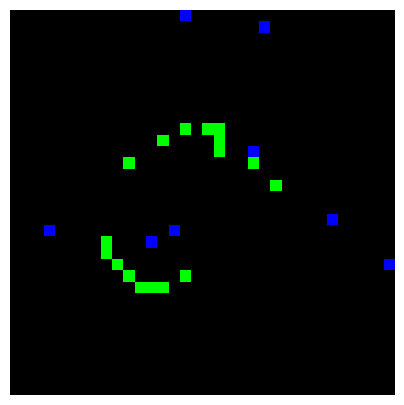

In [20]:
nmnist = tonic.datasets.NMNIST(save_to='./data', train=False)

events, label = nmnist[0]
transform = tonic.transforms.ToFrame(
    sensor_size=nmnist.sensor_size,
    time_window=10000,
)
frames = transform(events)
animation = tonic.utils.plot_animation(frames)

# Display the animation inline in a Jupyter notebook
from IPython.display import HTML
HTML(animation.to_jshtml())

During this task, we'll not train the network. We'll use already pretrained model (from UPeL course site). Use following line to upload `snn.pth` file, and then run cells with the SNN definition and loading of the weights.

In [ ]:
from google.colab import files
files.upload()

In [23]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Device: {device}')

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    )

testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=transform, train=False)
testloader = DataLoader(testset, batch_size=1, collate_fn=tonic.collation.PadTensors(batch_first=False))
net.load_state_dict(torch.load("snn.pth"))

Device: cuda


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./tmp/data/NMNIST/test.zip to ./tmp/data/NMNIST


<ipython-input-23-157f8df806ea>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("snn.pth"))


<All keys matched successfully>

Now, let's study the output of the SNN. As we already now, the output is in spiking format as well. We remember that for CNNs the output for MNIST classification is a 10-value vector, where each value refers to the probability that the object belongs to a particular class.

For SNNs we have a 10-value vector as well, but each can only be active or inactive (1 or 0). So how can we tell to which class do the objects belong? We just count the number of spikes registered for each class!

In the following code, we take a sample from dataset,  perform the forward-pass and visualize the output. Study it!

Event_tensor: torch.Size([30, 1, 2, 34, 34])
Spikes: torch.Size([30, 1, 10])
The target label is: tensor([0])


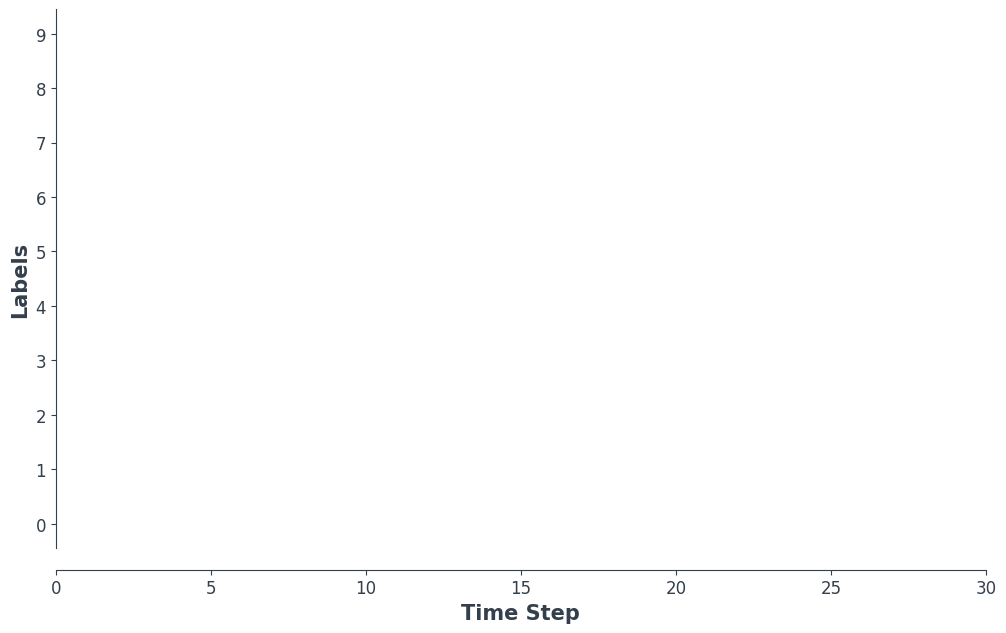

In [25]:
def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

event_tensor, target = next(iter(testloader))
print(f"Event_tensor: {event_tensor.shape}")
spk_rec = forward_pass(net, event_tensor)
print(f'Spikes: {spk_rec.shape}')
idx = 0
fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {target}")
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=5)
HTML(anim.to_html5_video())

That's it! There was not much for you to do in this part of the class. The teacher will ask you few questions about SNNs just to verify that you got the general idea :)